# Building a Spotify Recommendation Engine for Music Labels
## Cosine Similarity vs Clustering-Based Recommendation
### Flatiron School Data Science Program Phase 4 Project<br>Justin Williams & Khyatee Desai

In [327]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from zipfile import ZipFile 
from sklearn import set_config
from sklearn.cluster import KMeans
set_config(print_changed_only=False, display=None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import os
import sys
import statistics

# Spotify API Data Collection
The following process is used to collect song attributes for a user's given playlist from the Spotify API

In [328]:
# create a sample playlist
playlist = ['Only Child - Tierra Whack','Biscuit Town - King Krule', 
            'Bags - Clairo', 'Eventually - Tame Impala',
               'White Ferrari - Frank Ocean', 'Charcoal Baby - Blood Orange']

### Get spotify id's for each song

In [329]:
# save my credentials
os.environ["SPOTIPY_CLIENT_ID"] = "a8561b2ef375442f8f89527b255f4c78"
os.environ["SPOTIPY_CLIENT_SECRET"] = "566a59fd72764b9580f8767c5bc0ca7f"

spotify = spotipy.Spotify(auth_manager=SpotifyClientCredentials())

# save song id's, release dates, and song popularity in lists
song_ids = []
release_dates = []
popularities = []
for song in playlist:
    try:
        results = spotify.search(q=song, type='track')
        song_ids.append(results['tracks']['items'][0]['id'])
        release_dates.append(results['tracks']['items'][0]['album']['release_date'])
        popularities.append(results['tracks']['items'][0]['popularity'])
    except:
        print("Couldn't find:", song,'\n')

### Retrieve Song attributes for each song

In [330]:
# use the song id's gathered above to get audio attributes for each song
attributes = spotify.audio_features(tracks=song_ids)
attributes[0]

{'danceability': 0.826,
 'energy': 0.365,
 'key': 1,
 'loudness': -7.024,
 'mode': 1,
 'speechiness': 0.0412,
 'acousticness': 0.849,
 'instrumentalness': 3.8e-06,
 'liveness': 0.186,
 'valence': 0.802,
 'tempo': 85.244,
 'type': 'audio_features',
 'id': '4zMmqb0pYwX6b0qc0slCoT',
 'uri': 'spotify:track:4zMmqb0pYwX6b0qc0slCoT',
 'track_href': 'https://api.spotify.com/v1/tracks/4zMmqb0pYwX6b0qc0slCoT',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/4zMmqb0pYwX6b0qc0slCoT',
 'duration_ms': 239324,
 'time_signature': 4}

In [331]:
# combine the song popularity and release dates with the rest of the attributes
for i in range(len(attributes)):
    attributes[i]['track/artist'] = playlist[i]
    attributes[i]['popularity'] = popularities[i]
    attributes[i]['release_date'] = release_dates[i]
    
# create a dataframe from all the attributes
playlist_df = pd.DataFrame(attributes)

# Spotify Data Cleaning

### Create Decade Column

In [332]:
# drop unecessary features 
playlist_df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'time_signature'], axis=1, inplace=True)

# set release date as datetime
playlist_df['release_date'] = pd.to_datetime(playlist_df['release_date'])

# make year column datetime
playlist_df['year'] = playlist_df['release_date'].dt.year

# create decade column
playlist_df['decade'] = playlist_df['year'].apply(lambda x: str(x)[:3]+'0s')

### Map Keys/Modes to make more interpretable

In [333]:
# change keys/mode to letter/maj/min representations
keys = {0:'C', 1:'Db',2:'D',3:'Eb',4:'E',5:'F',6:'F#',7:'G',8:'Ab',9:'A',10:'Bb',11:'B'}
modes = {0:'Minor',1:'Major'}

# create new column in df
playlist_df['letter_keys'] = playlist_df['key'].map(keys)
playlist_df['modes'] = playlist_df['mode'].map(modes)

round(playlist_df['letter_keys'].value_counts(normalize=True)*100, 2)

G     33.33
Db    33.33
C     16.67
A     16.67
Name: letter_keys, dtype: float64

In [334]:
# create a column that concatonates key with mode
playlist_df['key_mode'] = playlist_df['letter_keys'] + " " + playlist_df['modes']

### Impute Outliers

In [335]:
# Bring outliers down/up to 5 standard deviations from the mean
for feat in playlist_df.columns:
    try:
        abv_5_std = playlist_df[feat].mean()+ 5* playlist_df[feat].std()
        below_5_std = playlist_df[feat].mean()- 5* playlist_df[feat].std()
        conditions = [playlist_df[feat]>abv_5_std, playlist_df[feat]<below_5_std]
        choices = [abv_5_std, below_5_std]
        df[feat] = np.select(conditions, choices, playlist_df[feat])
    except:
        pass

### Standardize

In [336]:
# Scale features down to 0-1
playlist_df['scaled_speech'] = (playlist_df['speechiness'] - min(playlist_df['speechiness'])) / (max(playlist_df['speechiness']) - min(playlist_df['speechiness']))
playlist_df['scaled_duration'] = (playlist_df['duration_ms'] - min(playlist_df['duration_ms'])) / (max(playlist_df['duration_ms']) - min(playlist_df['duration_ms']))
playlist_df['scaled_loudness'] = (playlist_df['loudness'] - min(playlist_df['loudness'])) / (max(playlist_df['loudness']) - min(playlist_df['loudness']))
playlist_df['scaled_tempo'] = (playlist_df['tempo'] - min(playlist_df['tempo'])) / (max(playlist_df['tempo']) - min(playlist_df['tempo']))
playlist_df['scaled_pop'] = (playlist_df['popularity'] - min(playlist_df['popularity'])) / (max(playlist_df['popularity']) - min(playlist_df['popularity']))


### Create Dummy Variables

In [337]:
# all the dummies from the big dataset
all_dummies = ['A Major', 'A Minor',
       'Ab Major', 'Ab Minor', 'B Major', 'B Minor', 'Bb Major', 'Bb Minor',
       'C Major', 'C Minor', 'D Major', 'D Minor', 'Db Major', 'Db Minor',
       'E Major', 'E Minor', 'Eb Major', 'Eb Minor', 'F Major', 'F Minor',
       'F# Major', 'F# Minor', 'G Major', 'G Minor', '1920s', '1930s', '1940s',
       '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s']

# make dummies for key/mode and decades
key_dummies = pd.get_dummies(playlist_df['key_mode'])
decade_dummies = pd.get_dummies(playlist_df['decade'])
dummies = pd.concat([ key_dummies, decade_dummies], axis=1)

# check which dummies weren't created - we need to add these in as zeros so the dataframes have the same shape
playlist_df = pd.concat([playlist_df, key_dummies, decade_dummies], axis=1)
zeroes = list(set(all_dummies) - set(dummies.columns))

# add those dummies in as zeroes
for col in zeroes:
    playlist_df[col] = 0

# drop first column for dummies
playlist_df.drop(['A Major', '1920s'],axis=1, inplace=True)

# Similarity-Based Recommendation
### Import Record Labels dataset

In [338]:
labels_df = pd.read_csv('data/cleaned_data_labels.csv',index_col=[0])

# drop unnecesary features
labels_df.drop(['key_mode', 'decade', 'modes', 'letter_keys',  'year', 
         'release_date', 'mode', 'loudness', 'key', 'id', 'explicit', 
         'tempo', 'duration_ms', 'speechiness', 'popularity' ], axis=1, inplace=True)

In [339]:
# dataframe of all Dead Oceans songs as a test sample
ocean_df = labels_df[labels_df.label == 'Dead Oceans']
ocean_df.head()

,acousticness,danceability,energy,instrumentalness,liveness,name,valence,scaled_speech,scaled_duration,scaled_loudness,scaled_tempo,scaled_pop,A Minor,Ab Major,Ab Minor,B Major,B Minor,Bb Major,Bb Minor,C Major,C Minor,D Major,D Minor,Db Major,Db Minor,E Major,E Minor,Eb Major,Eb Minor,F Major,F Minor,F# Major,F# Minor,G Major,G Minor,1930s,1940s,1950s,1960s,1970s,1980s,1990s,2000s,2010s,2020s,artist,label
2361,0.162000,0.181,0.486,0.2030,0.1110,Machine Gun,0.0545,0.152872,0.048459,0.716686,0.633260,0.40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,Slowdive,Dead Oceans
2362,0.098700,0.172,0.745,0.0073,0.2350,40 Days,0.4910,0.153282,0.035013,0.774223,0.757644,0.37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,Slowdive,Dead Oceans
2363,0.195000,0.129,0.647,0.2920,0.1040,Machine Gun,0.0393,0.156970,0.048824,0.792687,0.633165,0.41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,Slowdive,Dead Oceans
2364,0.001370,0.431,0.482,0.4410,0.2380,Ballad Of Sister Sue,0.1230,0.126232,0.049432,0.816804,0.524579,0.38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,Slowdive,Dead Oceans
2365,0.000057,0.227,0.480,0.8350,0.0477,Catch The Breeze,0.1880,0.159020,0.047115,0.841203,0.379780,0.37,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,Slowdive,Dead Oceans


### Cosine Similarities
Calculate cosine similarities between user playlist and all Dead Oceans songs

In [340]:
# turn both dataframes into numpy arrays
playlist_array = np.array(playlist_df.drop(['decade','duration_ms','key','key_mode','letter_keys',
                     'loudness','mode','modes','popularity','release_date','speechiness',
                         'tempo','track/artist','year'], axis=1))

label_array = np.array(ocean_df.drop(['artist','name','label'], axis=1))

In [341]:
# turn both arrays into sparse matrices
playlist_sparse = sparse.csr_matrix(playlist_array)
label_sparse = sparse.csr_matrix(label_array)

# get cosine similarities between user playlist and record label
cosim = cosine_similarity(playlist_sparse, label_sparse,dense_output=True)
print(cosim[0])


[0.38995135 0.4662626  0.48478512 0.39032257 0.42782616 0.46085464
 0.40797936 0.42228494 0.36705138 0.41266152 0.38307006 0.41039522
 0.36612965 0.47434809 0.4478603  0.41973825 0.46749903 0.39833034
 0.40234362 0.42874885 0.40731357 0.59508268 0.45724999 0.51824068
 0.416952   0.47831391 0.48171104 0.47370377 0.70959154 0.45684074
 0.51063887 0.40027611 0.53649436 0.55195587 0.51457329 0.52415796
 0.50444126 0.5201242  0.58733084 0.47541547 0.56191523 0.5597113
 0.53149898 0.48610826 0.507547   0.53378098 0.49634478 0.47988606
 0.49264427 0.46729198 0.52068869 0.51068665 0.51235597 0.48381973
 0.4762768  0.73862055 0.69600115 0.53838439 0.50662996 0.52052214
 0.58501887 0.49840562 0.50428994 0.47641281 0.53721815 0.49711914
 0.58439388 0.5147111  0.41407999 0.48300318 0.62214034 0.44768537
 0.43025633 0.39619925 0.5156551  0.46715186 0.52850753 0.54586033
 0.43923562 0.49850251 0.41135144]


### Make Recommendations
Sort by highest similarities and map the output to song names/artists

In [342]:
for i in range(len(cosim)):
    print('Dead Oceans songs similar to', playlist_df.iloc[i]['track/artist'],':\n' )
    print(sorted(list(zip(cosim[i],ocean_df['name'], ocean_df['artist'])), reverse=True)[:2])
    print('================================================================================================================')

Dead Oceans songs similar to Only Child - Tierra Whack :

[(0.7386205476184409, 'Scott Street', 'Phoebe Bridgers'), (0.709591542434846, 'Four Winds', 'Bright Eyes')]
Dead Oceans songs similar to Biscuit Town - King Krule :

[(0.6746890521982198, 'Day Glo', 'Brazos'), (0.6718588913492245, 'Four Winds', 'Bright Eyes')]
Dead Oceans songs similar to Bags - Clairo :

[(0.7481337481662697, 'Scott Street', 'Phoebe Bridgers'), (0.7001517172644336, 'Smoke Signals', 'Phoebe Bridgers')]
Dead Oceans songs similar to Eventually - Tame Impala :

[(0.6278176022682265, 'Scott Street', 'Phoebe Bridgers'), (0.6188202818501689, 'Smoke Signals', 'Phoebe Bridgers')]
Dead Oceans songs similar to White Ferrari - Frank Ocean :

[(0.6101156727757195, 'Scott Street', 'Phoebe Bridgers'), (0.5954600571939443, 'Smoke Signals', 'Phoebe Bridgers')]
Dead Oceans songs similar to Charcoal Baby - Blood Orange :

[(0.7575645674443352, 'Scott Street', 'Phoebe Bridgers'), (0.730893174543096, 'Smoke Signals', 'Phoebe Bridge

# Model Optimization
Put it all in functions, and generalize to any record label. If music label is not provided, the function will return songs from the label that is most similar to user's given playlist.

### Function: Collect Data from Spotify API

In [343]:
def spotifyAPI(playlist):
    '''input: user playlist of songs (list) in format [song name - artist, song name - artist, etc]
    Case insensitive.
        output: Pandas dataframe of raw song attributes collected from Spotify'''

    spotify = spotipy.Spotify(auth_manager=SpotifyClientCredentials())

    # save song id's, release dates, and song popularity in lists
    song_ids = []
    release_dates = []
    popularities = []
    for song in playlist:
        try:
            results = spotify.search(q=song, type='track')
            song_ids.append(results['tracks']['items'][0]['id'])
            release_dates.append(results['tracks']['items'][0]['album']['release_date'])
            popularities.append(results['tracks']['items'][0]['popularity'])
        except:
            print("Couldn't find:", song, '\n')
            pass

        
    # use the song id's gathered above to get audio attributes for each song
    attributes = spotify.audio_features(tracks=song_ids)
    
    # combine the song popularity and release dates with the rest of the attributes
    for i in range(len(attributes)):
        attributes[i]['track/artist'] = playlist[i]
        attributes[i]['popularity'] = popularities[i]
        attributes[i]['release_date'] = release_dates[i]

    # create a dataframe from all the attributes
    playlist_df = pd.DataFrame(attributes)
    return playlist_df

### Function: Clean and Prep Raw Dataframe

In [344]:
def clean(playlist_df):
    '''input: Pandas dataframe of raw spotify song attributes collected from Spotify API
        output: Cleaned dataframe, with dummy variables and fewer unnecessary columns'''
    
    
    # drop unecessary features 
    playlist_df.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'time_signature'], axis=1, inplace=True)

    # set release date as datetime
    playlist_df['release_date'] = pd.to_datetime(playlist_df['release_date'])

    # make year column datetime
    playlist_df['year'] = playlist_df['release_date'].dt.year

    # create decade column
    playlist_df['decade'] = playlist_df['year'].apply(lambda x: str(x)[:3]+'0s')
    
    # change keys/mode to letter/maj/min representations
    keys = {0:'C', 1:'Db',2:'D',3:'Eb',4:'E',5:'F',6:'F#',7:'G',8:'Ab',9:'A',10:'Bb',11:'B'}
    modes = {0:'Minor',1:'Major'}

    # create new column in df
    playlist_df['letter_keys'] = playlist_df['key'].map(keys)
    playlist_df['modes'] = playlist_df['mode'].map(modes)

    # create a column that concatonates key with mode
    playlist_df['key_mode'] = playlist_df['letter_keys'] + " " + playlist_df['modes']
    
    # Bring outliers down/up to 5 standard deviations from the mean
    for feat in playlist_df.columns:
        try:
            abv_5_std = playlist_df[feat].mean()+ 5* playlist_df[feat].std()
            below_5_std = playlist_df[feat].mean()- 5* playlist_df[feat].std()
            conditions = [playlist_df[feat]>abv_5_std, playlist_df[feat]<below_5_std]
            choices = [abv_5_std, below_5_std]
            df[feat] = np.select(conditions, choices, playlist_df[feat])
        except:
            pass
        
    # Scale features down to 0-1
    playlist_df['scaled_speech'] = (playlist_df['speechiness'] - min(playlist_df['speechiness'])) / (max(playlist_df['speechiness']) - min(playlist_df['speechiness']))
    playlist_df['scaled_duration'] = (playlist_df['duration_ms'] - min(playlist_df['duration_ms'])) / (max(playlist_df['duration_ms']) - min(playlist_df['duration_ms']))
    playlist_df['scaled_loudness'] = (playlist_df['loudness'] - min(playlist_df['loudness'])) / (max(playlist_df['loudness']) - min(playlist_df['loudness']))
    playlist_df['scaled_tempo'] = (playlist_df['tempo'] - min(playlist_df['tempo'])) / (max(playlist_df['tempo']) - min(playlist_df['tempo']))
    playlist_df['scaled_pop'] = (playlist_df['popularity'] - min(playlist_df['popularity'])) / (max(playlist_df['popularity']) - min(playlist_df['popularity']))

    # all the dummies from the big dataset
    all_dummies = ['A Major', 'A Minor',
           'Ab Major', 'Ab Minor', 'B Major', 'B Minor', 'Bb Major', 'Bb Minor',
           'C Major', 'C Minor', 'D Major', 'D Minor', 'Db Major', 'Db Minor',
           'E Major', 'E Minor', 'Eb Major', 'Eb Minor', 'F Major', 'F Minor',
           'F# Major', 'F# Minor', 'G Major', 'G Minor', '1920s', '1930s', '1940s',
           '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', '2010s', '2020s']

    # make dummies for key/mode and decades
    key_dummies = pd.get_dummies(playlist_df['key_mode'])
    decade_dummies = pd.get_dummies(playlist_df['decade'])
    dummies = pd.concat([ key_dummies, decade_dummies], axis=1)

    # check which dummies weren't created - we need to add these in as zeros so the dataframes have the same shape
    playlist_df = pd.concat([playlist_df, key_dummies, decade_dummies], axis=1)
    zeroes = list(set(all_dummies) - set(dummies.columns))

    # add those dummies in as zeroes
    for col in zeroes:
        playlist_df[col] = 0

    # drop first column for dummies
    playlist_df.drop(['A Major', '1920s'],axis=1, inplace=True)
    return(playlist_df)

### Function: Make Recommendations

In [369]:
def get_recs(playlist, record_label=None):
    '''input 1: user playlist of songs (list) in format 
            [song name - artist, song name - artist, etc.] Case insensitive.
    input 2: (optional) record label name (string.) If record label not provided,
        function will use label that is most similar to user's given playlist.
    output: Playlist (text output) including Record label name, and recommended songs
        '''
    
    # collect and clean spotify data based on user's playlist
    raw_playlist_df = spotifyAPI(playlist)
    clean_playlist_df = clean(raw_playlist_df)

    # import record labels dataset
    labels_df = pd.read_csv('data/cleaned_data_labels.csv',index_col=[0])

    # drop unnecesary features
    labels_df.drop(['key_mode', 'decade', 'modes', 'letter_keys',  'year', 
             'release_date', 'mode', 'loudness', 'key', 'id', 'explicit', 
             'tempo', 'duration_ms', 'speechiness', 'popularity' ], axis=1, inplace=True)
    
    label_pool=[]
    if not record_label:
        label_pool = labels_df.label.unique()
    else:
        label_pool.append(record_label)    
    
    label_dict={}
    for label in label_pool:
        # dataframe of all specified label's songs
        label_df = labels_df[labels_df.label == label]

        # turn both dataframes into numpy arrays
        playlist_array = np.array(clean_playlist_df.drop(['decade','duration_ms','key',
                        'key_mode','letter_keys','loudness','mode','modes','popularity',
                        'release_date','speechiness','tempo','track/artist','year'], axis=1))
        label_array = np.array(label_df.drop(['artist','name','label'], axis=1))

        # turn both arrays into sparse matrices
        playlist_sparse = sparse.csr_matrix(playlist_array)
        label_sparse = sparse.csr_matrix(label_array)

        # get cosine similarities between user playlist and record label
        # cosim contains multiple arrays, one for each song from user playlist
        label_dict[label] =cosine_similarity(playlist_sparse, label_sparse,dense_output=True) 

    # flatten each song cosim per label and put in dictionary
    mean_cosims ={}
    for key in label_dict:
        flattened_cosim = [item for items in label_dict[key] for item in items]
        mean_cosims[statistics.mean(sorted(flattened_cosim)[:10])] = key
    
    # find best record label by getting one with largest avg cosine sim
    best_label = (mean_cosims[sorted(mean_cosims, reverse=True)[0]])
    label_df = labels_df[labels_df.label == best_label]
    song_cosims = label_dict[best_label]
    
    # go through best label and get track name and artist with highest cosim
    recs=[]
    for song_cosim in song_cosims:
        four_best = sorted(list(zip(song_cosim,label_df['name'], label_df['artist'])), reverse=True)[:4]
        recs.append((four_best[0][1]+', by '+ four_best[0][2]))

    # remove duplicates, add a different song
    recs_no_dup = list(set(recs))
    if len(recs_no_dup)< len(recs):
        recs_no_dup.append((four_best[1][1]+', by '+ four_best[1][2]))
        
    # output the results
    if not record_label:
        print("We think you're gonna like",best_label,'records!')
    print(best_label,'songs similar to your playlist:\n')
    for song in recs_no_dup:
        print(song)

### Test the Function

In [346]:
# feed in XL Records songs, to see if we get songs from XL records back
XL_playlist = ["Shabop Shalom - Devendra Banhart", "jasmine - demo - Jai Paul",
               "I Think I Smell A Rat - The White Stripes", "Hometown Glory - Adele",
                "Close To You - The Avalanches"]
get_recs(XL_playlist, 'XL')

Couldn't find: I Think I Smell A Rat - The White Stripes 

XL songs similar to your playlist:

Sunflower (feat. Steve Lacy), by Vampire Weekend
When I Hear My Name, by The White Stripes
Rolling in the Deep, by Adele
Shabop Shalom, by Devendra Banhart


# Cluster-Based Recommendation
Now we use k-means clustering to generate recommendations
### Collect/Clean Sample Playlist

In [237]:
# create a sample playlist
playlist = ['Only Child - Tierra Whack','Biscuit Town - King Krule', 
            'Bags - Clairo', 'Eventually - Tame Impala',
               'White Ferrari - Frank Ocean', 'Charcoal Baby - Blood Orange']

In [238]:
# Use the above functions to collect song attributes and clean data from Spotify API
raw_playlist_df = spotifyAPI(playlist)
playlist_df = clean(raw_playlist_df)

# create name and artist columns from track/artist
playlist_df['name'] = playlist_df['track/artist'].apply(lambda x: x.split(' - ')[0])
playlist_df['artist'] = playlist_df['track/artist'].apply(lambda x: x.split(' - ')[1])

# label each playlist song in new column
playlist_df['playlist_track'] = 1

# drop unnecessary features
playlist_df.drop(['track/artist','decade','duration_ms','key','key_mode','letter_keys',
                     'loudness','mode','modes','popularity','release_date','speechiness',
                         'tempo','year'], axis=1, inplace=True)
label_df = ocean_df.drop(['label'], axis=1)

# label each label track as 0 in the playlist column
label_df['playlist_track'] = 0

### Concat playlist and label dataframes

In [239]:
# create main dataframe using playlist songs and all label's songs, to be fed into model
main_df = pd.concat([playlist_df, label_df], axis=0).reset_index(drop=True)

# convert main dataframe to array
main_array = np.array(main_df.drop(['name', 'artist','playlist_track'], axis=1))

### K-Means Clustering

In [240]:
# instantiate kmeans class and set n_clusters
k_means = KMeans(random_state=1, n_clusters=6) # default n_clusters = 8

# fit to data
k_means.fit(main_array)

# predict which clusters each song belongs too
predicted_clusters = k_means.fit_predict(main_array)

# each instance was assigned to one of the clusters
predicted_clusters 

array([3, 3, 2, 2, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 5, 0, 0, 0, 5, 0, 5, 1, 5, 0, 0, 0, 0,
       5, 0, 2, 2, 2, 0, 2, 2, 4, 4, 2, 2, 3, 2, 2, 4, 4, 3, 3, 4, 2, 5,
       3, 0, 2, 5, 0, 2, 2, 0, 4, 2, 3, 4, 2, 2, 2, 2, 5, 3, 2, 3, 0],
      dtype=int32)

In [241]:
# concatenate cluster labels with main dataframe
pred_series = pd.Series(predicted_clusters)
main_df_w_pred = pd.concat([main_df, pred_series], axis=1)
main_df_w_pred.rename(columns={0:'cluster'},inplace=True)

### Inspect Each Cluster

In [242]:
# Inspect songs in cluster 0
main_df_w_pred[['name', 'artist', 'cluster', 'playlist_track']][main_df_w_pred.cluster==0]

,name,artist,cluster,playlist_track
28,"Sunrise, Sunset",Bright Eyes,0,0
29,Land Locked Blues,Bright Eyes,0,0
30,Road To Joy,Bright Eyes,0,0
32,Poison Oak,Bright Eyes,0,0
33,Devil Town,Bright Eyes,0,0
34,Four Winds,Bright Eyes,0,0
36,The Calendar Hung Itself…,Bright Eyes,0,0
40,"Haligh, Haligh, A Lie, Haligh",Bright Eyes,0,0
41,First Day Of My Life,Bright Eyes,0,0
42,Lua,Bright Eyes,0,0


In [248]:
# Inspect songs in cluster 4
main_df_w_pred[['name', 'artist', 'cluster','playlist_track']][main_df_w_pred.cluster==4]

,name,artist,cluster,playlist_track
52,So We Won't Forget,Khruangbin,4,0
53,Zionsville,Khruangbin,4,0
59,Two Fish and an Elephant,Khruangbin,4,0
60,A Calf Born in Winter,Khruangbin,4,0
63,I See You,Phoebe Bridgers,4,0
74,Last Words of a Shooting Star,Mitski,4,0
77,Francis Forever,Mitski,4,0


### Make Recommendations

In [249]:
# look at the clusters most similar to user's playlist
relevant_clusters = main_df_w_pred['cluster'][main_df_w_pred.playlist_track==1]

# drop the user playlist songs from df, so they aren't recommended again
pred_df = main_df_w_pred.drop(main_df_w_pred[main_df_w_pred.playlist_track==1].index)

In [250]:
# return one random recommendation from each cluster
recs=[]
for k in relevant_clusters:
    recs +=pred_df[['name', 'artist']][pred_df.cluster==k].sample(1, random_state=543).values.tolist()
    pred_df.drop(pred_df[['name', 'artist']][pred_df.cluster==k].sample(1, random_state=543).index,inplace=True)

print('Dead Oceans songs similar to your playlist:\n')
for song in recs:
    print(song[0]+', by '+ song[1])

Dead Oceans songs similar to your playlist:

Smoke Signals, by Phoebe Bridgers
Motion Sickness, by Phoebe Bridgers
First Love / Late Spring, by Mitski
Your Best American Girl, by Mitski
White Gloves, by Khruangbin
Sugaree, by Phosphorescent


### Visualize Clusters - need to work on this

In [251]:
# get cluster centers from .cluster_centers_ attribute
centers = k_means.cluster_centers_

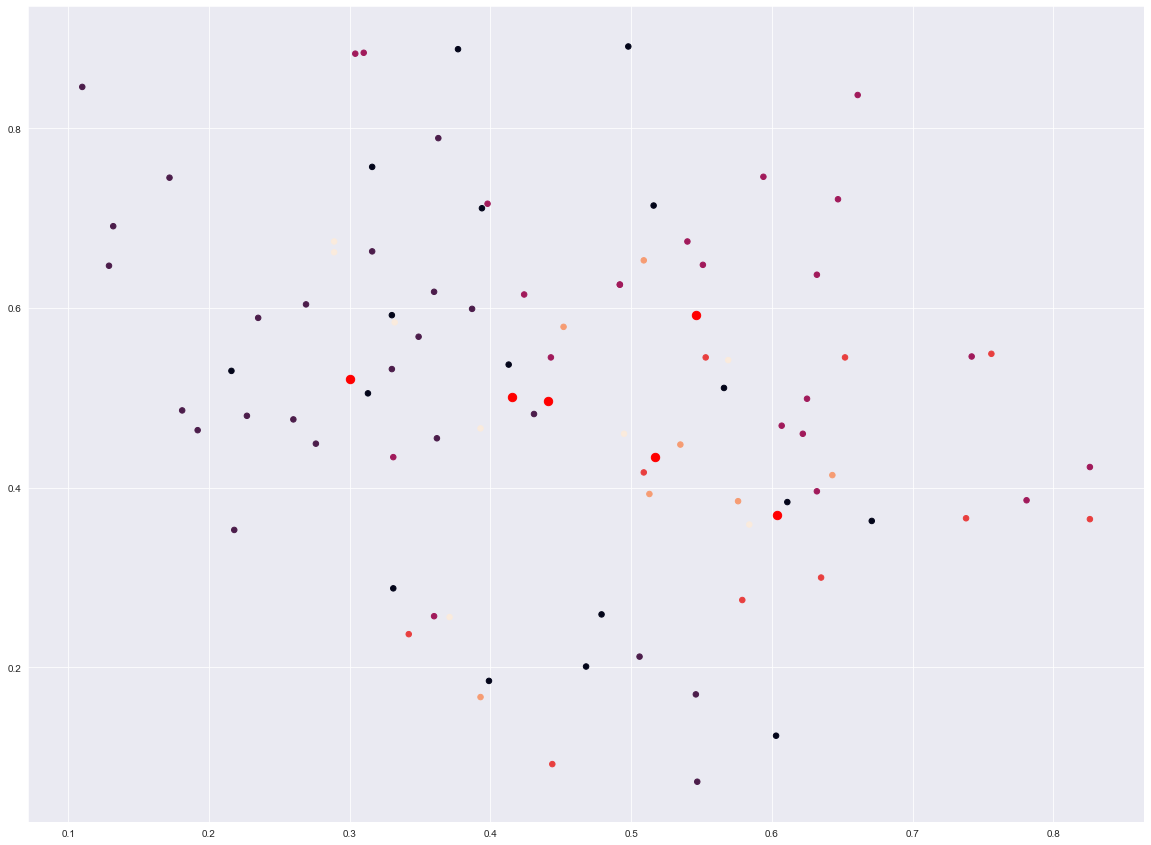

In [252]:
# scatter plot of clusters and their centroids.
plt.figure(figsize=(20,15))
plt.scatter(main_array[:,0], main_array[:,1], c=predicted_clusters, s=30);
# plt.scatter(playlist_array[:,0], playlist_array[:,1], c='b', s=10);
plt.scatter(centers[:,0], centers[:,1], s=70, c='red');

### Inspect Distortion

In [253]:
# use distortion as metric to classify similarities betwen songs within df
distortion = []
for k in range(1, 26):  
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(label_array)
    distortion.append(kmeans.inertia_) # inertia_: sum of squared distances of samples to their closest cluster center

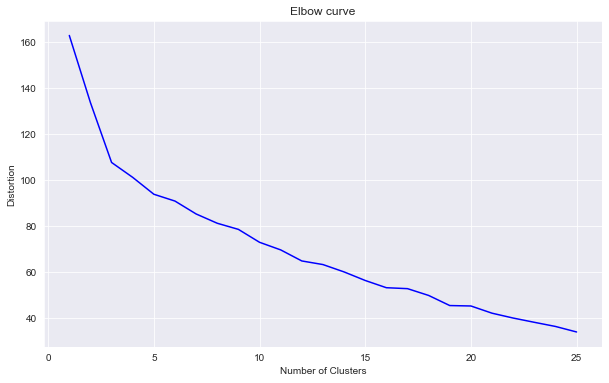

In [254]:
# try elbow plot to find best k for this cluster
fig = plt.figure(figsize=(10, 6))
plt.plot(range(1, 26), distortion, c = 'b')
plt.xlabel('Number of Clusters')
plt.ylabel('Distortion')
plt.title('Elbow curve')
plt.show()

# Clustering Optimization
Put it all in a function to generalize for any music label and playlist

In [378]:
def cluster_recs(playlist, label):
    '''input 1: user playlist 
        input 2: music label name (string)
        output: '''
    
    # Use the above functions to collect song attributes and clean data from Spotify API
    raw_playlist_df = spotifyAPI(playlist)
    playlist_df = clean(raw_playlist_df)

    # create name and artist columns from track/artist
    playlist_df['name'] = playlist_df['track/artist'].apply(lambda x: x.split(' - ')[0])
    playlist_df['artist'] = playlist_df['track/artist'].apply(lambda x: x.split(' - ')[1])

    # label each playlist song in new column
    playlist_df['playlist_track'] = 1

    # drop unnecessary features
    playlist_df.drop(['track/artist','decade','duration_ms','key','key_mode','letter_keys',
                         'loudness','mode','modes','popularity','release_date','speechiness',
                             'tempo','year'], axis=1, inplace=True)
    label_df = labels_df[labels_df.label == label].drop(['label'], axis=1)

    # label each label track as 0 in the playlist column
    label_df['playlist_track'] = 0
    
    # create main dataframe using playlist songs and all label's songs, to be fed into model
    main_df = pd.concat([playlist_df, label_df], axis=0).reset_index(drop=True)

    # convert main dataframe to array
    main_array = np.array(main_df.drop(['name', 'artist','playlist_track'], axis=1))
    
    # instantiate kmeans class and set n_clusters
    k_means = KMeans(random_state=1, n_clusters=6) # default n_clusters = 8

    # fit to data
    k_means.fit(main_array)

    # predict which clusters each song belongs too
    predicted_clusters = k_means.fit_predict(main_array)
    
    # concatenate cluster labels with main dataframe
    pred_series = pd.Series(predicted_clusters)
    main_df_w_pred = pd.concat([main_df, pred_series], axis=1)
    main_df_w_pred.rename(columns={0:'cluster'},inplace=True)

    # look at the clusters most similar to user's playlist
    relevant_clusters = main_df_w_pred['cluster'][main_df_w_pred.playlist_track==1]
    
    # drop the user playlist songs from df, so they aren't recommended again
    pred_df = main_df_w_pred.drop(main_df_w_pred[main_df_w_pred.playlist_track==1].index)
    
    # return one random recommendation from each cluster
    recs=[]
    for k in relevant_clusters:
        try:
            recs +=pred_df[['name', 'artist']][pred_df.cluster==k].sample(1, random_state=543).values.tolist()
            pred_df.drop(pred_df[['name', 'artist']][pred_df.cluster==k].sample(1, random_state=543).index,inplace=True)
        except:
            pass
    print(label,'songs similar to your playlist:\n')
    for song in recs:
        print(song[0]+', by '+ song[1])

# Model Evaluation & A/B Testing
Using empirical evaluation methods to compare the recommenders
## ** in progress**

### Khyatee
Cosim Model:

In [524]:
khyatees_playlist = ['Polly - Moses Sumney', 'Tal Uno - Barrie',
               'Butterfly - Adrianne Lenker',
               'All of Me Wants All of You - Sufjan Stevens','Cola - Arlo Parks']

get_recs(khyatees_playlist, '4AD')

4AD songs similar to your playlist:

Let's Dance, by M. Ward
How to Bring a Blush to the Snow, by Cocteau Twins
Hinnom, TX, by Bon Iver
Elephant Gun, by Beirut
Dive, by Bauhaus


Clustering Model:

In [525]:
cluster_recs(khyatees_playlist, '4AD')

4AD songs similar to your playlist:

Life's Greatest Fool, by Gene Clark
29 #Strafford APTS, by Bon Iver
I Need My Girl, by The National
Revival, by Deerhunter
He Would Have Laughed, by Deerhunter


### J-Will

Cosim model

In [528]:
jwill_playlist = ["Step into You - HUM", "Venus Principle - Popol Vuh", 
        "A Fabricated Life - Nothing", "Clear Language - Balmorhea", "anything - Adrianne Lenker"]

get_recs(jwill_playlist, 'Interscope')


Couldn't find: Venus Principle - Popol Vuh 

Interscope songs similar to your playlist:

Let It Go, by Playboi Carti
Art Deco, by Lana Del Rey
Cinderella Man, by Eminem
Still D.R.E. - Instrumental, by Dr. Dre


Cluster model

In [529]:
cluster_recs(jwill_playlist, 'Interscope')

Couldn't find: Venus Principle - Popol Vuh 

Interscope songs similar to your playlist:

Born This Way, by Lady Gaga
Window, by Still Woozy
Good For You, by Selena Gomez
This Love Isn't Crazy, by Carly Rae Jepsen


### Fangfang
Cosim Model:

In [512]:
fangfang_playlist = ["lost in yesterday - tame impala", "maria también - khruangbin",
                    "girl - the internet"]
get_recs(fangfang_playlist, 'Dead Oceans')

Dead Oceans songs similar to your playlist:

Day Glo, by Brazos
It's Gonna Take an Airplane, by Destroyer
Here She Comes, by Slowdive


Cluster model:

In [513]:
cluster_recs(fangfang_playlist, 'Dead Oceans')

Dead Oceans songs similar to your playlist:

So We Won't Forget, by Khruangbin
Zionsville, by Khruangbin
Nobody, by Mitski


### Josh

Cosim Model:

In [505]:
josh_playlist = ["(nothing but) flowers - talking heads", "new year's eve - tom waits", 
                 "cherry-coloured funk - cocteau twins", 
                 "time enough for rocking when we're old - the magnetic fields", 
                 "some loud thunder - clap your hands say yeah"]
get_recs(josh_playlist, '4AD')

Couldn't find: time enough for rocking when we're old - the magnetic fields 

4AD songs similar to your playlist:

Santa Fe, by Beirut
A Love From Outer Space, by A.R. Kane
Let's Dance, by M. Ward
Little Dreamer, by Future Islands


Cluster Model:

In [506]:
cluster_recs(josh_playlist, '4AD')

Couldn't find: time enough for rocking when we're old - the magnetic fields 

4AD songs similar to your playlist:

Little Spacey, by Cocteau Twins
29 #Strafford APTS, by Bon Iver
Miss Modular, by Stereolab
Amerimacka featuring Notch, by Thievery Corporation


### Nick

In [487]:
nicks_playlist =["Patrona - Lao Ra", "SALTA - Mitu", "Ela Minus, Grammy - Jenn Morel", 
                 "Ecko, Algo Nuevo - La Dona", "Pity - Navy"]
get_recs(nicks_playlist, 'Atlantic')

Couldn't find: Ela Minus, Grammy - Jenn Morel 

Couldn't find: Ecko, Algo Nuevo - La Dona 

Atlantic songs similar to your playlist:

Geek'd (feat. Lil Baby), by Bhad Bhabie
I'm Yours, by Jason Mraz
Strawberry Shortcake, by Melanie Martinez


In [492]:
cluster_recs(nicks_playlist, 'Atlantic')

Couldn't find: Ela Minus, Grammy - Jenn Morel 

Couldn't find: Ecko, Algo Nuevo - La Dona 

Atlantic songs similar to your playlist:

These Days, by Wallows
I Follow Rivers - The Magician Remix, by Lykke Li
Bad Bad, by YoungBoy Never Broke Again


### Ismael
Cosim Model:

In [477]:
ismael_playlist = ['believe - mumford & sons', 'remembering sunday - all time low', 
                   'should have known better - sufjan stevens']
get_recs(ismael_playlist, 'Sub Pop')

Sub Pop songs similar to your playlist:

Hiphopopotamus vs. Rhymenoceros, by Flight of the Conchords
About A Girl, by Nirvana
Zebra, by Beach House


Cluster model:

In [478]:
cluster_recs(ismael_playlist, 'Sub Pop')

Sub Pop songs similar to your playlist:

All We Ever Knew, by The Head and the Heart
The World At Large, by Modest Mouse
Shake, by The Head and the Heart


### Amelia

In [416]:
amelia_playlist = ["first class - rainbow kitten surprise", 
                "silver lining - mt. joy", "soulfight - the revivalists"]
get_recs(amelia_playlist, 'Transgressive')

Transgressive songs similar to your playlist:

Samson, by Regina Spektor
Hero, by Regina Spektor
Birthday Suit, by Cosmo Sheldrake


In [417]:
cluster_recs(amelia_playlist, 'Transgressive')

Transgressive songs similar to your playlist:

This Song Is Not About A Girl, by Flume
Rushing Back, by Flume
Flightless Bird, American Mouth, by Iron & Wine


### Sidney

In [474]:
sidney_playlist = ["Down To Earth - UMI", "Love Affair - UMI", "Streets - Doja Cat", 
                   "SUGAR - BROCKHAMPTON", "You Sad - Tkay Maidza", "Hair Down - SiR", 
                   "CRAZY - Jessie Reyez"]
get_recs(sidney_playlist, 'Island')

Island songs similar to your playlist:

The Calm, by Drake
Lookalike, by Conan Gray
My Everything, by Ariana Grande
Chicago Freestyle (feat. Giveon), by Drake
Never Be Alone, by Shawn Mendes
There's Nothing Holdin' Me Back, by Shawn Mendes
The Birds Pt. 2, by The Weeknd


In [424]:
cluster_recs(sidney_playlist, 'Island')

Island songs similar to your playlist:

Let It Go - From "Frozen / Single Version, by Demi Lovato
Why Won't You Make Up Your Mind?, by Tame Impala
Below My Feet, by Mumford & Sons
Lovers' Eyes, by Mumford & Sons
Lie To Me, by Bon Jovi
Behind Barz - Bonus, by Drake
Hold On, We're Going Home, by Drake


### Justin F

In [467]:
justinF_playlist =["Monsters - All Time Low", "Weightless - All Time Low", 
                   "Getaway Green - All Time Low", "Stupid for you - Waterparks", 
                   "Turbulent - Waterparks"]
get_recs(justinF_playlist, 'Atlantic')

Atlantic songs similar to your playlist:

Make It Rain, by Ed Sheeran
Jesus In LA, by Alec Benjamin
I Warned Myself, by Charlie Puth
Floyd Mayweather (feat. Travis Scott, Gucci Mane and Gunna), by Young Thug
I'm Yours, by Jason Mraz


In [466]:
cluster_recs(justinF_playlist, 'Atlantic')

Atlantic songs similar to your playlist:

Bad Bad, by YoungBoy Never Broke Again
Passenger Seat, by Death Cab for Cutie
Knocked Off, by YoungBoy Never Broke Again
I Follow Rivers - The Magician Remix, by Lykke Li
First of the Year (Equinox), by Skrillex


### Eric

In [430]:
eric_playlist = ["Dua Lipa - don't start now", "Lady Gaga - fun tonight", "Ava Max - salt", 
        "Galantis - Faith", "Gryffin - Feel Good"]
get_recs(eric_playlist, 'Interscope')

Interscope songs similar to your playlist:

my strange addiction, by Billie Eilish
We Work The Black Seam, by Sting
If I Believe You, by The 1975
Hazardous Youth - A Cappella, by Eminem
Your Song, by Ellie Goulding


In [431]:
cluster_recs(eric_playlist,'Interscope')

Interscope songs similar to your playlist:

dothatshit!, by Playboi Carti
Born This Way, by Lady Gaga
Window, by Still Woozy
Good For You, by Selena Gomez
The Heart Wants What It Wants, by Selena Gomez


### Daniel

In [455]:
daniel_playlist = ['Hunnybee - Unknown Mortal Orchestra',
                    'Me, Myself & I - Oliver Tree',
                    'Prune, You Talk Funny - Gus Dapperton']
get_recs(daniel_playlist, 'XL')

XL songs similar to your playlist:

Backdrifts, by Radiohead
Storm Music, by Gil Scott-Heron
Sunflower (feat. Steve Lacy), by Vampire Weekend


In [456]:
cluster_recs(daniel_playlist, 'XL')

XL songs similar to your playlist:

Rumour Has It, by Adele
All Along The Watchtower, by Bobby Womack
Take It All, by Adele


### DJ

In [451]:
dj_playlist = ["King of the beach - Wavves",
            "Rocket man - Elton John",
            "Take me away - Scotty Sire"]
get_recs(dj_playlist, 'Matador')

Matador songs similar to your playlist:

March Into the Sea, by Modest Mouse
Border Line, by King Krule
Let's Move To The Country, by Smog


In [452]:
cluster_recs(dj_playlist, 'Matador')

Matador songs similar to your playlist:

If I Had A Tail, by Queens of the Stone Age
Wagon Wheel, by Lou Reed
My God Is The Sun, by Queens of the Stone Age


### Lauren

In [448]:
lauren_playlist = ["imi - bon iver", "now im in it - haim", "kyoto - phoebe bridgers"]
get_recs(lauren_playlist, 'Dead Oceans')

Dead Oceans songs similar to your playlist:

Sing, by Slowdive
It's Gonna Take an Airplane, by Destroyer
I Hear You Calling, by Bill Fay


In [435]:
cluster_recs(lauren_playlist, 'Dead Oceans')

Dead Oceans songs similar to your playlist:

Sugaree, by Phosphorescent
So We Won't Forget, by Khruangbin
I See You, by Phoebe Bridgers


### David Bruce

In [444]:
davidB_playlist = ["heavy metal drummer - wilco",
                    "disparate youth - santigold",
                    "the heart is a muscle - gang of youths"]
get_recs(davidB_playlist, 'Fat Possum')

Fat Possum songs similar to your playlist:

Black Mud, by The Black Keys
If I Needed You, by Townes Van Zandt
Mr. Mudd & Mr. Gold - Live, by Townes Van Zandt


In [445]:
cluster_recs(davidB_playlist, 'Fat Possum')

Fat Possum songs similar to your playlist:

The General Specific, by Band of Horses
Next Girl, by The Black Keys
Little Black Submarines, by The Black Keys


### Jake Heyman

In [436]:
jakeH_playlist = ["space song - beach house",
                    "Fitzpleasure - Alt-j",
                    "Interstellar love - The Avalanches"]
get_recs(jakeH_playlist, 'Sub Pop')

Sub Pop songs similar to your playlist:

Robots, by Flight of the Conchords
Pollo Asado, by Ween
Have You Forgotten, by Red House Painters


In [437]:
cluster_recs(jakeH_playlist, 'Sub Pop')

Sub Pop songs similar to your playlist:

All We Ever Knew, by The Head and the Heart
Shake, by The Head and the Heart
ELO Kiddies - Single Version, by Cheap Trick
